In [1]:
#From Chapter 11 of Joel Grus' "Data Science from Scratch"

import random
from typing import TypeVar, List, Tuple
X = TypeVar('X')  # generic type to represent a data point

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

data = [n for n in range(1000)]
train, test = split_data(data, 0.75)

# The proportions should be correct
assert len(train) == 750
assert len(test) == 250

# And the original data should be preserved (in some order)
assert sorted(train + test) == data

In [2]:
Y = TypeVar('Y')  # generic type to represent output variables

def train_test_split(xs: List[X],
                     ys: List[Y],
                     test_pct: float) -> Tuple[List[X], List[X], List[Y], List[Y]]:
    # Generate the indices and split them.
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

xs = [x for x in range(1000)]  # xs are 0 ... 999
ys = [2 * x for x in xs]       # each y_i is twice x_i
x_train, x_test, y_train, y_test = train_test_split(xs, ys, 0.25)

# Check that the proportions are correct
assert len(x_train) == len(y_train) == 750
assert len(x_test) == len(y_test) == 250

# Check that the corresponding data points are paired correctly.
assert all(y == 2 * x for x, y in zip(x_train, y_train))
assert all(y == 2 * x for x, y in zip(x_test, y_test))

In [3]:
x_train[:5], y_train[:5]

([984, 704, 392, 481, 931], [1968, 1408, 784, 962, 1862])

In [4]:
def accuracy(tp: int, fp: int, fn: int, tn: int) -> float:
    correct = tp + tn
    total = tp + fp + fn + tn
    return correct / total

assert accuracy(70, 4930, 13930, 981070) == 0.98114

def precision(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fp)

assert precision(70, 4930, 13930, 981070) == 0.014

def recall(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fn)

assert recall(70, 4930, 13930, 981070) == 0.005

def f1_score(tp: int, fp: int, fn: int, tn: int) -> float:
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)

    return 2 * p * r / (p + r)

In [5]:
f1_score(1000, 10, 10, 1000)

0.9900990099009901

In [6]:
model = SomeKindOfModel()
x_train, x_test, y_train, y_test = train_test_split(xs, ys, 0.33)
model.train(x_train, y_train)
performance = model.test(x_test, y_test)

NameError: name 'SomeKindOfModel' is not defined

In [9]:
#Machine learning: the k-Nearest Neighbors algorithm

from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

In [10]:
from typing import NamedTuple
import math

Vector = List[float]

def subtract(v: Vector, w: Vector) -> Vector:
    assert len(v) == len(w), "minuend and subtrahend have different lengths"
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v: Vector, w: Vector) -> float:
    assert len(v) == len(w), "vectors have different lengths"
    
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def norm_square(v: Vector) -> float:
    return dot(v, v)

def norm(v: Vector) -> float:
    return math.sqrt(norm_square(v))

def distance(v: Vector, w: Vector) -> float:
    return norm(subtract(v, w))

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

In [14]:
# EXAMPLE (Botany)
    
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    #class is, e.g., "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]
    
    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]
    
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

In [17]:
points_by_species['virginica']

[[6.3, 3.3, 6.0, 2.5],
 [5.8, 2.7, 5.1, 1.9],
 [7.1, 3.0, 5.9, 2.1],
 [6.3, 2.9, 5.6, 1.8],
 [6.5, 3.0, 5.8, 2.2],
 [7.6, 3.0, 6.6, 2.1],
 [4.9, 2.5, 4.5, 1.7],
 [7.3, 2.9, 6.3, 1.8],
 [6.7, 2.5, 5.8, 1.8],
 [7.2, 3.6, 6.1, 2.5],
 [6.5, 3.2, 5.1, 2.0],
 [6.4, 2.7, 5.3, 1.9],
 [6.8, 3.0, 5.5, 2.1],
 [5.7, 2.5, 5.0, 2.0],
 [5.8, 2.8, 5.1, 2.4],
 [6.4, 3.2, 5.3, 2.3],
 [6.5, 3.0, 5.5, 1.8],
 [7.7, 3.8, 6.7, 2.2],
 [7.7, 2.6, 6.9, 2.3],
 [6.0, 2.2, 5.0, 1.5],
 [6.9, 3.2, 5.7, 2.3],
 [5.6, 2.8, 4.9, 2.0],
 [7.7, 2.8, 6.7, 2.0],
 [6.3, 2.7, 4.9, 1.8],
 [6.7, 3.3, 5.7, 2.1],
 [7.2, 3.2, 6.0, 1.8],
 [6.2, 2.8, 4.8, 1.8],
 [6.1, 3.0, 4.9, 1.8],
 [6.4, 2.8, 5.6, 2.1],
 [7.2, 3.0, 5.8, 1.6],
 [7.4, 2.8, 6.1, 1.9],
 [7.9, 3.8, 6.4, 2.0],
 [6.4, 2.8, 5.6, 2.2],
 [6.3, 2.8, 5.1, 1.5],
 [6.1, 2.6, 5.6, 1.4],
 [7.7, 3.0, 6.1, 2.3],
 [6.3, 3.4, 5.6, 2.4],
 [6.4, 3.1, 5.5, 1.8],
 [6.0, 3.0, 4.8, 1.8],
 [6.9, 3.1, 5.4, 2.1],
 [6.7, 3.1, 5.6, 2.4],
 [6.9, 3.1, 5.1, 2.3],
 [5.8, 2.7, 5.1, 1.9],
 [6.8, 3.2,

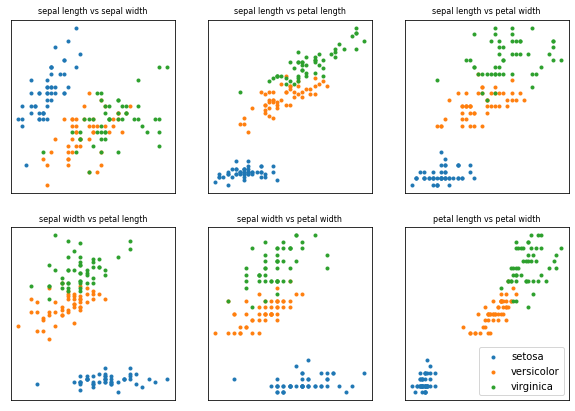

In [18]:
from matplotlib import pyplot as plt

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['.','.','.']

fig, ax = plt.subplots(2, 3, figsize=(10,7))

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize = 8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker = mark, label = species)

ax[-1][-1].legend(loc = 'lower right')
#plt.show

In [29]:
import random

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

#random.seed(137)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150
    
from typing import Tuple
    
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
    
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
                num_correct += 1
    
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)    

0.9555555555555556 defaultdict(<class 'int'>, {('setosa', 'setosa'): 19, ('versicolor', 'versicolor'): 16, ('virginica', 'versicolor'): 2, ('virginica', 'virginica'): 8})


Curse of Dimensionality: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


([<matplotlib.lines.Line2D at 0x165638f5520>],
 [<matplotlib.lines.Line2D at 0x165638f5820>])

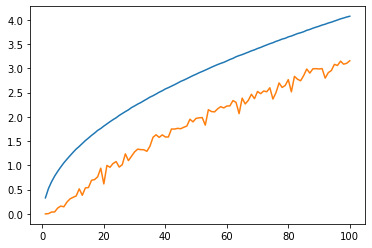

In [30]:
import tqdm
dimensions = range(1, 101)
    
avg_distances = []
min_distances = []
    
random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum
    
min_avg_ratio = [min_dist / avg_dist
                     for min_dist, avg_dist in zip(min_distances, avg_distances)]

plt.plot(dimensions, avg_distances), plt.plot(dimensions, min_distances)